<a href="https://colab.research.google.com/github/ttped/DS-Unit-2-Linear-Models/blob/master/DS-Unit-2-Linear-Models/Trevor_Pedersen_LS_DS_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [ ]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [ ]:
#look for null counts and correct dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48817 entries, 0 to 49351
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             48817 non-null  float64
 1   bedrooms              48817 non-null  int64  
 2   created               48817 non-null  object 
 3   description           47392 non-null  object 
 4   display_address       48684 non-null  object 
 5   latitude              48817 non-null  float64
 6   longitude             48817 non-null  float64
 7   price                 48817 non-null  int64  
 8   street_address        48807 non-null  object 
 9   interest_level        48817 non-null  object 
 10  elevator              48817 non-null  int64  
 11  cats_allowed          48817 non-null  int64  
 12  hardwood_floors       48817 non-null  int64  
 13  dogs_allowed          48817 non-null  int64  
 14  doorman               48817 non-null  int64  
 15  dishwasher         

In [ ]:
#convert created to proper datetime format
df['created'] = pd.to_datetime(df['created'])

dtype('<M8[ns]')

In [ ]:
#look at top 5
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#change index to date
df = df.set_index('created')
df.head()

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-24 07:54:24,1.5,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-06-12 12:19:27,1.0,2,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-17 03:26:41,1.0,1,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-18 02:22:02,1.0,1,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-28 01:32:41,1.0,4,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#sort dates in proper order
df = df.sort_index()
df

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-01 22:12:41,1.0,1,X-LARGE Flex 1BR Loft! ~~ PRIME Greenwich Vill...,Astor Place,40.7302,-73.9924,3195,1 Astor Place,high,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:56:00,1.0,0,"This Enormous Studio Features: Harwood Floors,...",East 54th Street,40.7576,-73.9677,2000,230 East 54th Street,medium,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:57:15,2.0,3,--- East 31st St & Lexington Avenue --- This S...,East 31st St & Lexington Avenue,40.7388,-73.9851,5850,105 Lexington Avenue,high,1,1,0,1,1,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2016-04-01 23:26:07,1.0,1,Reduced Fee!! Priced To Rent!\rLarge Newly Upd...,West End Ave,40.7939,-73.9738,2745,700 West End Ave,medium,1,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2016-04-02 00:48:13,1.0,1,Phenomenal deal of the century!! This spacious...,E 88th street,40.7784,-73.9491,2400,401 E 88th street,medium,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-29 17:47:34,1.0,2,"Newly renovated, clean, quiet & very bright 2...",At Thompson St,40.7261,-74.0014,3045,132 Thompson St #20,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-06-29 17:56:12,1.0,1,Historic conversion in Greenpoint with awesome...,"100 Dupont St, Brooklyn, NY 11222",40.7358,-73.9560,2648,100 Dupont St,low,1,1,0,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2016-06-29 18:14:48,1.0,1,"Large, sunny one bedroom apartment with a sepa...",West 45th St. and 8th Ave.,40.7597,-73.9890,2650,305 West 45th St.,low,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#replace nan descriptions with empty string
df['description'] = df['description'].fillna('')

In [ ]:
#feature engineering
#going to create a column that is the length of the description
df['description length'] = df['description'].apply(len)

In [ ]:
df[['description', 'description length']]

,description,description length
created,,
2016-04-01 22:12:41,X-LARGE Flex 1BR Loft! ~~ PRIME Greenwich Vill...,94
2016-04-01 22:56:00,"This Enormous Studio Features: Harwood Floors,...",357
2016-04-01 22:57:15,--- East 31st St & Lexington Avenue --- This S...,411
2016-04-01 23:26:07,Reduced Fee!! Priced To Rent!\rLarge Newly Upd...,816
2016-04-02 00:48:13,Phenomenal deal of the century!! This spacious...,536
...,...,...
2016-06-29 17:47:34,"Newly renovated, clean, quiet & very bright 2...",208
2016-06-29 17:56:12,Historic conversion in Greenpoint with awesome...,381
2016-06-29 18:14:48,"Large, sunny one bedroom apartment with a sepa...",327


In [ ]:
#feature engineering
#adding frequency of description to look for generic copy/paste descriptions

df['description frequency'] = df.groupby('description')['description'].transform('count')

In [ ]:
#looking at length and frequency counts sorted by frequency
df[['description', 'description length', 'description frequency']].sort_values('description frequency', ascending=False)

,description,description length,description frequency
created,,,
2016-06-07 04:18:18,,8,1627
2016-05-18 03:19:41,,8,1627
2016-04-06 08:04:51,,8,1627
2016-04-15 05:19:43,,8,1627
2016-04-06 08:02:26,,8,1627
...,...,...,...
2016-05-06 04:34:48,Spacious 3 bedroom apartment with a separate k...,640,1
2016-05-06 04:35:04,Facing the back open views with trees. Easily ...,202,1
2016-05-06 04:35:27,100% NO BROKER FEE!! PLUS 1 MONTH FREE!!NEW Lu...,1016,1


In [ ]:
#We have a bunch of whitespace strings so I'm going to replace them with empty strings using regex
df['description'] = df['description'].replace(r'^\s*$', '', regex=True)

In [ ]:
#Rerun feature engineering
df['description length'] = df['description'].apply(len)
df['description frequency'] = df.groupby('description')['description'].transform('count')

In [ ]:
#Now our empty strings are all the same
df[['description', 'description length', 'description frequency']].sort_values('description frequency', ascending=False)

,description,description length,description frequency
created,,,
2016-06-04 01:40:12,,0,3288
2016-04-06 08:07:02,,0,3288
2016-04-06 08:09:22,,0,3288
2016-04-15 05:14:18,,0,3288
2016-04-06 08:09:43,,0,3288
...,...,...,...
2016-05-06 04:34:48,Spacious 3 bedroom apartment with a separate k...,640,1
2016-05-06 04:35:04,Facing the back open views with trees. Easily ...,202,1
2016-05-06 04:35:27,100% NO BROKER FEE!! PLUS 1 MONTH FREE!!NEW Lu...,1016,1


In [ ]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


price = 3142.5334527700925 + 0.7265614187380727 x description length 



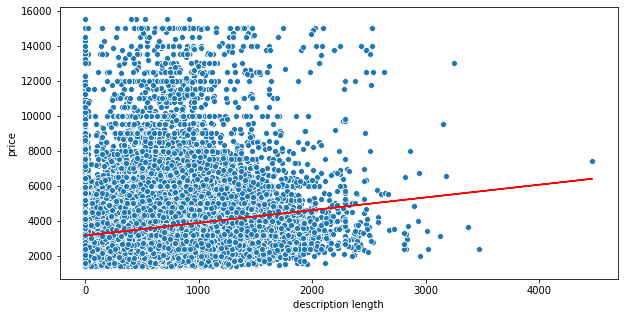

In [ ]:
model = LinearRegression()

target = 'price'
feature = 'description length'

y = df[target]
X = df[[feature]]

model.fit(X,y)

y_pred = model.predict(X)

fig, ax = plt.subplots(figsize=(10,5))

#ax.plot(X,y)
ax.plot(X, y_pred, color='red')
sns.scatterplot(x=feature, y=target, data=df)
plt.plot()

print(f'{target} = {model.intercept_} + {model.coef_[0]} x {feature} \n')

In [ ]:
#testing a lambda function for a mask
temp = df.index.map(lambda x: x.month in range(4,6) and x.year == 2016)
temp = temp.map(lambda x: not x)
temp

Index([False, False, False, False, False, False, False, False, False, False,
       ...
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
      dtype='object', name='created', length=48817)

In [ ]:
def lin_reg(df, target, features):
  # Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
  mask = df.index.map(lambda x: x.month in range(4,6) and x.year == 2016)
  invert_mask = mask.map(lambda x: not x)

  X = df[[features]]
  y = df[target]

  X_train, y_train = X.loc[mask], y.loc[mask]
  X_val, y_val = X.loc[invert_mask], y.loc[invert_mask]

  model = LinearRegression()
  model.fit(X_train, y_train)

  y_pred = model.predict(X_val)

  print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
  print('Validation MAE:', mean_absolute_error(y_val, model.predict(X_val)))

  print("Traning RMSE:", mean_squared_error(y_train, model.predict(X_train), squared=False))
  print("Validation RMSE:", mean_squared_error(y_val, model.predict(X_val), squared=False))

  print("Training R-squared score is:", model.score(X_train, y_train))
  print("Validation R-squared is:", model.score(X_val, y_val))

  print(f'{target} = {model.intercept_} + {model.coef_[0]} x {feature} \n')
  
  fig, ax = plt.subplots(figsize=(10,5))

  ax.scatter(X_val, y_val)
  ax.plot(X_val, y_pred, color='red')
  plt.plot()

Training MAE: 1190.831789272141
Validation MAE: 1179.0855687944677
Traning RMSE: 1740.2004683623243
Validation RMSE: 1737.4925042223545
Training R-squared score is: 0.024711707082295198
Validation R-squared is: 0.028680970283477047


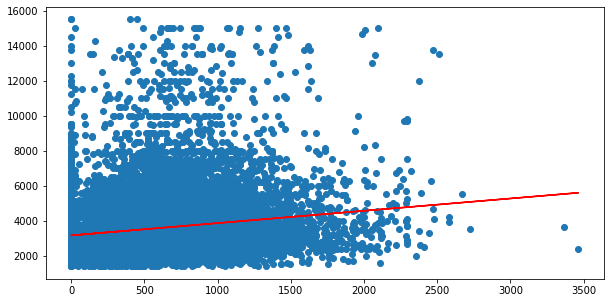

In [ ]:
lin_reg(df, 'price', 'description length')

Training R-squared score is: 0.0002852485779047953
validation R-squared is: 0.0003869847652558933


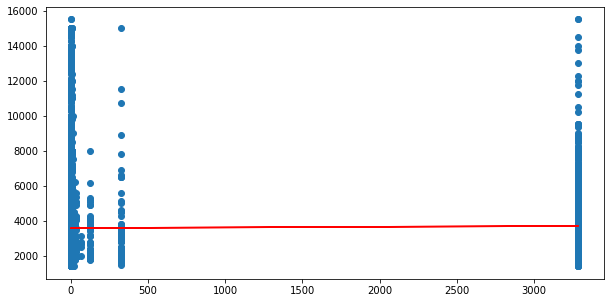

In [ ]:
lin_reg(df, 'price', 'description frequency')

In [ ]:
#Feature engineering
#convert interest levels into numeric type
df['interest_level_numeric'] = df['interest_level'].map(lambda x: 1 if x == 'low' else (2 if x == 'medium' else (3 if x == 'high' else 0)))

In [ ]:
df[['interest_level', 'interest_level_numeric']]

,interest_level,interest_level_numeric
created,,
2016-04-01 22:12:41,high,3
2016-04-01 22:56:00,medium,2
2016-04-01 22:57:15,high,3
2016-04-01 23:26:07,medium,2
2016-04-02 00:48:13,medium,2
...,...,...
2016-06-29 17:47:34,medium,2
2016-06-29 17:56:12,low,1
2016-06-29 18:14:48,low,1


Training R-squared score is: 0.04058544356008298
validation R-squared is: 0.04302593119734899


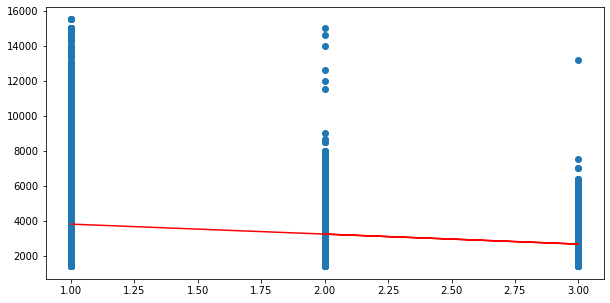

In [ ]:
#My interpretation is that interest increases as the price lowers
lin_reg(df, 'price', 'interest_level_numeric')

In [ ]:
def mult_lin_reg(df, target, features_arr):
  # Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
  mask = df.index.map(lambda x: x.month in range(4,6) and x.year == 2016)
  invert_mask = mask.map(lambda x: not x)

  X = df[features_arr]
  y = df[target]

  X_train, y_train = X.loc[mask], y.loc[mask]
  X_val, y_val = X.loc[invert_mask], y.loc[invert_mask]

  model = LinearRegression()
  model.fit(X_train, y_train)

  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

  print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
  print('Validation MAE:', mean_absolute_error(y_val, model.predict(X_val)), '\n')

  print("Traning RMSE:", mean_squared_error(y_train, model.predict(X_train), squared=False))
  print("Validation RMSE:", mean_squared_error(y_val, model.predict(X_val), squared=False), '\n')

  print("Training R-squared score is:", model.score(X_train, y_train))
  print("Validation R-squared is:", model.score(X_val, y_val), '\n')

  #print(f'{target} = {model.intercept_} + {model.coef_} x {features_arr} \n')

  for i, feature in enumerate(features_arr):
    print(f'{target} = {model.intercept_} + {model.coef_[i]} x {feature}')
    #print(i, feature)


  #print(y_pred)

  #fig, ax = plt.subplots(figsize=(10,5))

  #ax.scatter(X_val, y_val)
  #ax.plot(X_val, y_pred, color='red')
  #plt.plot()

In [ ]:
mult_lin_reg(df, 'price', ['interest_level_numeric', 'description length'])

Training MAE: 1161.2184357261615
Validation MAE: 1147.5221346000249 

Traning RMSE: 1699.8291295039144
Validation RMSE: 1694.6992467718962 

Training R-squared score is: 0.06943870820202602
Validation R-squared is: 0.07593761770053797 

price = 3942.5202644643327 + -599.6276066780911 x interest_level_numeric
price = 3942.5202644643327 + 0.7619297968117573 x description length


In [ ]:
print(df.columns)

Index(['bathrooms', 'bedrooms', 'description', 'display_address', 'latitude',
       'longitude', 'price', 'street_address', 'interest_level', 'elevator',
       'cats_allowed', 'hardwood_floors', 'dogs_allowed', 'doorman',
       'dishwasher', 'no_fee', 'laundry_in_building', 'fitness_center',
       'pre-war', 'laundry_in_unit', 'roof_deck', 'outdoor_space',
       'dining_room', 'high_speed_internet', 'balcony', 'swimming_pool',
       'new_construction', 'terrace', 'exclusive', 'loft', 'garden_patio',
       'wheelchair_access', 'common_outdoor_space', 'description length',
       'description frequency', 'interest_level_numeric'],
      dtype='object')


In [ ]:
mult_lin_reg(df, 'price', ['bathrooms', 'bedrooms', 'latitude',
       'longitude', 'elevator',
       'cats_allowed', 'hardwood_floors', 'dogs_allowed', 'doorman',
       'dishwasher', 'no_fee', 'laundry_in_building', 'fitness_center',
       'pre-war', 'laundry_in_unit', 'roof_deck', 'outdoor_space',
       'dining_room', 'high_speed_internet', 'balcony', 'swimming_pool',
       'new_construction', 'terrace', 'exclusive', 'loft', 'garden_patio',
       'wheelchair_access'])

Training MAE: 692.9393619372084
Validation MAE: 701.2729238609654 

Traning RMSE: 1090.1771821161494
Validation RMSE: 1078.5511772034865 

Training R-squared score is: 0.6172381682206225
Validation R-squared is: 0.6257192143827344 

price = -1078110.5125647315 + 1768.3178862360428 x bathrooms
price = -1078110.5125647315 + 478.57601002379613 x bedrooms
price = -1078110.5125647315 + 1658.8160495994084 x latitude
price = -1078110.5125647315 + -13667.033605114428 x longitude
price = -1078110.5125647315 + 148.4650026783584 x elevator
price = -1078110.5125647315 + -37.477952717374286 x cats_allowed
price = -1078110.5125647315 + -205.14396903149537 x hardwood_floors
price = -1078110.5125647315 + 96.76593842310716 x dogs_allowed
price = -1078110.5125647315 + 481.2277579548375 x doorman
price = -1078110.5125647315 + 54.26312399305608 x dishwasher
price = -1078110.5125647315 + -166.80724810031614 x no_fee
price = -1078110.5125647315 + -294.11915209492173 x laundry_in_building
price = -1078110.51

In [ ]:
#Select all columns that are numeric excluding "price"
features = df.select_dtypes(include=['float64', 'int64']).drop(columns='price').columns

mult_lin_reg(df, 'price', features)

Training MAE: 671.6417989628633
Validation MAE: 674.8132264011433 

Traning RMSE: 1060.5423883167134
Validation RMSE: 1044.6567087156095 

Training R-squared score is: 0.6377649159722018
Validation R-squared is: 0.6488738187372343 

price = -1021836.4861727087 + 1708.9581280759312 x bathrooms
price = -1021836.4861727087 + 488.1843288796094 x bedrooms
price = -1021836.4861727087 + 1278.3997178267282 x latitude
price = -1021836.4861727087 + -13122.804795303531 x longitude
price = -1021836.4861727087 + 141.85327049616495 x elevator
price = -1021836.4861727087 + -35.351966351138834 x cats_allowed
price = -1021836.4861727087 + -138.27923861558946 x hardwood_floors
price = -1021836.4861727087 + 68.49807010018012 x dogs_allowed
price = -1021836.4861727087 + 425.25030741569907 x doorman
price = -1021836.4861727087 + 53.10194055570463 x dishwasher
price = -1021836.4861727087 + -105.04515350204369 x no_fee
price = -1021836.4861727087 + -87.07581493755322 x laundry_in_building
price = -1021836.48

In [ ]:
#non numeric columns
non_numeric = df.select_dtypes(exclude=['float64', 'int64']).columns
df[non_numeric]

,description,display_address,street_address,interest_level
created,,,,
2016-04-01 22:12:41,X-LARGE Flex 1BR Loft! ~~ PRIME Greenwich Vill...,Astor Place,1 Astor Place,high
2016-04-01 22:56:00,"This Enormous Studio Features: Harwood Floors,...",East 54th Street,230 East 54th Street,medium
2016-04-01 22:57:15,--- East 31st St & Lexington Avenue --- This S...,East 31st St & Lexington Avenue,105 Lexington Avenue,high
2016-04-01 23:26:07,Reduced Fee!! Priced To Rent!\rLarge Newly Upd...,West End Ave,700 West End Ave,medium
2016-04-02 00:48:13,Phenomenal deal of the century!! This spacious...,E 88th street,401 E 88th street,medium
...,...,...,...,...
2016-06-29 17:47:34,"Newly renovated, clean, quiet & very bright 2...",At Thompson St,132 Thompson St #20,medium
2016-06-29 17:56:12,Historic conversion in Greenpoint with awesome...,"100 Dupont St, Brooklyn, NY 11222",100 Dupont St,low
2016-06-29 18:14:48,"Large, sunny one bedroom apartment with a sepa...",West 45th St. and 8th Ave.,305 West 45th St.,low


In [ ]:
#finish the rest of feature engineering
'''
Does the apartment have a description? Done
How long is the description? Done
How many total perks does each apartment have? Done
Are cats or dogs allowed? Done
Are cats and dogs allowed? Done
Total number of rooms (beds + baths)
Ratio of beds to baths
What's the neighborhood, based on address or latitude & longitude?
'''

In [ ]:
df[['dogs_allowed', 'cats_allowed']]

,dogs_allowed,cats_allowed
created,,
2016-04-01 22:12:41,0,0
2016-04-01 22:56:00,1,1
2016-04-01 22:57:15,1,1
2016-04-01 23:26:07,1,1
2016-04-02 00:48:13,1,1
...,...,...
2016-06-29 17:47:34,0,0
2016-06-29 17:56:12,1,1
2016-06-29 18:14:48,1,1


In [ ]:
#feature engineering
#check if apartments allows both cats and dogs
df['cats_and_dogs'] = ((df['cats_allowed'] == 1) & (df['dogs_allowed'] == 1)).map(lambda x: 1 if x == True else 0)
#df['cats_and_dogs'] = df['cats_and_dogs'].map(lambda x: 1 if x == True else 0)
df['cats_and_dogs']

created
2016-04-01 22:12:41    0
2016-04-01 22:56:00    1
2016-04-01 22:57:15    1
2016-04-01 23:26:07    1
2016-04-02 00:48:13    1
                      ..
2016-06-29 17:47:34    0
2016-06-29 17:56:12    1
2016-06-29 18:14:48    1
2016-06-29 18:30:41    1
2016-06-29 21:41:47    0
Name: cats_and_dogs, Length: 48817, dtype: int64

In [ ]:
#Feature engineering cats or dogs
df['cats_or_dogs'] = ((df['cats_allowed'] == 1) | (df['dogs_allowed'] == 1)).map(lambda x: 1 if x == True else 0)
df['cats_or_dogs']

created
2016-04-01 22:12:41    0
2016-04-01 22:56:00    1
2016-04-01 22:57:15    1
2016-04-01 23:26:07    1
2016-04-02 00:48:13    1
                      ..
2016-06-29 17:47:34    0
2016-06-29 17:56:12    1
2016-06-29 18:14:48    1
2016-06-29 18:30:41    1
2016-06-29 21:41:47    0
Name: cats_or_dogs, Length: 48817, dtype: int64

In [ ]:
#Feature engineering
#Sum of perks
#Grab all the feature columns
temp = df.isin([0,1]).all()
temp = temp[temp == True]
columns = temp.index
df['perk_sum'] = df[columns].sum(axis=1)
df['perk_sum']

created
2016-04-01 22:12:41     3
2016-04-01 22:56:00     6
2016-04-01 22:57:15    11
2016-04-01 23:26:07    10
2016-04-02 00:48:13     7
                       ..
2016-06-29 17:47:34     0
2016-06-29 17:56:12     9
2016-06-29 18:14:48     7
2016-06-29 18:30:41     4
2016-06-29 21:41:47     0
Name: perk_sum, Length: 48817, dtype: int64

In [ ]:
#Feature engineering
#Total number of rooms
df['room_total'] = df[['bathrooms', 'bedrooms']].sum(axis=1)

In [ ]:
#Grabs all numeric columns
features = df.select_dtypes(include=['float64', 'int64']).drop(columns='price').columns

#Use all columns for prediction
mult_lin_reg(df, 'price', features)

Training MAE: 671.6254129404207
Validation MAE: 674.9289537180761 

Traning RMSE: 1060.5258394950831
Validation RMSE: 1044.746289542486 

Training R-squared score is: 0.6377762205972503
Validation R-squared is: 0.6488135969973774 

price = -1021808.0924162565 + 976.5810122991616 x bathrooms
price = -1021808.0924162565 + -244.21885108042997 x bedrooms
price = -1021808.0924162565 + 1277.5765417045923 x latitude
price = -1021808.0924162565 + -13122.881110780267 x longitude
price = -1021808.0924162565 + 111.82646833054663 x elevator
price = -1021808.0924162565 + 32.928022694415354 x cats_allowed
price = -1021808.0924162565 + -168.41560068206283 x hardwood_floors
price = -1021808.0924162565 + -76.08847235637757 x dogs_allowed
price = -1021808.0924162565 + 395.3264191166596 x doorman
price = -1021808.0924162565 + 23.47448092047841 x dishwasher
price = -1021808.0924162565 + -134.99503798698765 x no_fee
price = -1021808.0924162565 + -115.95542596925972 x laundry_in_building
price = -1021808.09